<a href="https://colab.research.google.com/github/yuvvantalreja/twitter-sentiment-analysis/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Roadmap

1. Import Dataset
2. Split Dataset into Training, Testing and Validation
3. Convert to dataset
4. Convert to dataloaders --> BATCH_SIZE = 8
5. Create model class
6. Train model
7. Evaluate Model
8. Induvisual Predictions
9. Experimenting and Improving Model

In [1]:
!pip -q install regex requests hydra-core omegaconf bitarray wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import torch
from torch import nn

torch.__version__

'2.3.0+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
import requests
import os
import zipfile
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import wordcloud
import seaborn as sns
import transformers
from transformers import RobertaModel, RobertaTokenizer
from transformers import AutoTokenizer

In [6]:
data_path = Path("")

# If image folder doesn't exist commence download
if data_path.is_dir():
  print(f"{data_path} directory already exists... skipping download")
else:
  print(f"Image path doesn't exist creating one...")
  data_path.mkdir(parents = True, exist_ok = True)

with open(data_path/"data.zip", "wb") as f:
  request = requests.get("https://github.com/yuvvantalreja/twitter-sentiment-analysis/raw/main/data.zip")
  print("Downloading data")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path/"data.zip", "r") as zip_ref:
  print("Unzipping data")
  zip_ref.extractall(data_path)

. directory already exists... skipping download
Unzipping data


In [7]:
!file -bi /content/training.1600000.processed.noemoticon.csv

text/csv; charset=utf-8


In [8]:
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding='latin-1')

In [9]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [10]:
df.drop(df.columns[1:5], axis=1, inplace=True)

In [11]:
df.columns = ['Target', 'Text']

In [12]:
df['Target'].unique()

array([0, 4])

In [13]:
df.head()

,Target,Text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [21]:
df['Text'][:10]

0    is upset that he can't update his Facebook by ...
1    @Kenichan I dived many times for the ball. Man...
2      my whole body feels itchy and like its on fire 
3    @nationwideclass no, it's not behaving at all....
4                        @Kwesidei not the whole crew 
5                                          Need a hug 
6    @LOLTrish hey  long time no see! Yes.. Rains a...
7                 @Tatiana_K nope they didn't have it 
8                            @twittera que me muera ? 
9          spring break in plain city... it's snowing 
Name: Text, dtype: object

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Target'], test_size = 0.25)

In [23]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1199999, 400000, 1199999, 400000)

In [24]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [25]:
X_train.head(), y_train.head()

(0    Morning.... my Sister is off to the American W...
 1    Wondering why my boy picked tonight to scream ...
 2    @khrism Oy. I really need a different job... i...
 3    And yet, a nice thunderstorm to help me sleep ...
 4    @ElliottXGrey So, what, you just don't want to...
 Name: Text, dtype: object,
 0    4
 1    0
 2    0
 3    4
 4    0
 Name: Target, dtype: int64)

In [26]:
X_test.head(), y_test.head()

(0    Took a test this morning... worked out my rage...
 1                                    no one is on msn 
 2    okay, off to sleep! so excited i found filters...
 3    @liampete Thank you!  I shall take that as a c...
 4    G'night world. Am heading to bed with a smile ...
 Name: Text, dtype: object,
 0    4
 1    0
 2    4
 3    4
 4    4
 Name: Target, dtype: int64)

In [ ]:
X_train.shape, y_train.shape

((1199999,), (1199999,))

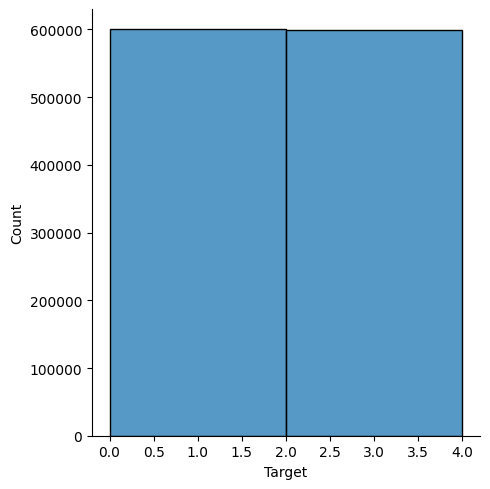

In [ ]:
sns.displot(y_train, binwidth = 2)

In [ ]:
class TwitterDataset(Dataset):
  def __init__(self, features, labels, tokenizer, max_len):
    self.features = features
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    inputs = self.tokenizer.encode_plus(self.features[index],
                                        None,
                                        add_special_tokens=True,
                                        max_length= self.max_len,
                                        pad_to_max_length=True,
                                        return_token_type_ids=True,
                                        return_attention_mask = True,
                                        truncation = True)
    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]

    return {
      'ids': torch.tensor(ids, dtype=torch.long).flatten(),
      'mask': torch.tensor(mask, dtype=torch.long).flatten(),
      'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
      'targets': torch.tensor(self.labels[index], dtype=torch.float)
    }

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", model_max_length=MAX_LEN)

In [ ]:
tokenizer("Hello world")

{'input_ids': [0, 31414, 232, 2], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
pad_index = tokenizer.pad_token_id
pad_index

1

In [ ]:
input = tokenizer.encode_plus(df['Text'][1], None, add_special_tokens=True, max_length= 256, pad_to_max_length=True, return_token_type_ids=True)
input

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'input_ids': [0, 1039, 28524, 1725, 260, 38, 385, 19133, 171, 498, 13, 5, 1011, 4, 1554, 4628, 7, 1871, 654, 207, 1437, 20, 1079, 213, 66, 9, 22772, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
train_set = TwitterDataset(features = X_train, labels = y_train, tokenizer = tokenizer, max_len = MAX_LEN)
test_set = TwitterDataset(X_test, y_test, tokenizer, MAX_LEN)

In [ ]:
train_set.__getitem__(0)

{'ids': tensor([    0,   975,   857,     6, 10982, 47510,   439,    62,    12,   350,
          1099,    89,    32,   164,     7,    28,   132,  4050,   734,  1437,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,  

In [ ]:
len(train_set)

1199999

In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["targets"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch_mask = [i["mask"] for i in batch]
        batch_mask = [item for sublist in batch_mask for item in sublist]
        batch_mask = torch.tensor(batch_mask, dtype=torch.long)
        batch_token_type_ids = [i["token_type_ids"] for i in batch]
        batch_token_type_ids = [item for sublist in batch_token_type_ids for item in sublist]
        batch_token_type_ids = torch.tensor(batch_token_type_ids, dtype = torch.long)
        batch = {"ids": batch_ids, "mask": batch_mask, "token_type_ids": batch_token_type_ids, "targets": batch_label}
        return batch

    return collate_fn

In [ ]:
train_dataloader = DataLoader(train_set, TRAIN_BATCH_SIZE, num_workers = os.cpu_count(), shuffle = True, collate_fn = get_collate_fn(pad_index))
test_dataloader = DataLoader(test_set, VALID_BATCH_SIZE, num_workers = os.cpu_count(), shuffle = False)

In [ ]:
len(train_dataloader)

150000

In [ ]:
batch = next(iter(train_dataloader))
batch["mask"][0]

tensor(1)

In [ ]:
class RobertaClass(nn.Module):
  def __init__(self):
    super(RobertaClass, self).__init__()
    self.pretrained_layer = RobertaModel.from_pretrained("roberta-base")
    self.pre_classifier = torch.nn.Linear(768, 768)
    self.classifier = torch.nn.Linear(768, 1)
    torch.nn.init.xavier_uniform_(self.pre_classifier.weight)
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.dropout = torch.nn.Dropout(0.3)


  def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
    output = self.pretrained_layer(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    pooled_output = self.pre_classifier(pooled_output)
    pooled_output = self.dropout(pooled_output)
    pooled_output = F.relu(pooled_output)
    logits = self.classifier(pooled_output)
    return logits

In [ ]:
def accuracy(predicitons, targets):
  '''Calculate accuracy of model: Model output => tensor or array?'''


In [ ]:
model = RobertaClass()
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (pretrained_layer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_params(model):,} trainable parameters")

The model has 125,236,993 trainable parameters


In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
EPOCHS = 1

def train_step(epoch, model, dataloader, optimizer, device):
  model.train()
  tr_loss = []
  for _,data in tqdm(enumerate(dataloader, 1)):
    ids = data["ids"].to(device)
    mask = data["mask"].to(device)
    token_type_ids = data["token_type_ids"].to(device)
    targets = data["targets"].to(device)

    logits = model(ids, mask, token_type_ids)

    loss = loss_fn(logits)
    tr_loss.append(loss)

    # accuracy =

    optimizer.zero_grad()
    loss.backeard()
    optimizer.step()

    print(f"Training loss: {loss}")


In [ ]:
def test_step(epoch, model, dataloader, loss, optimizer, device):
  model.eval()
  ts_loss = []
  with torch.inference_mode():
    for _, data in tqdm(enumerate(test_dataloader, 0)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
      targets = data['targets'].to(device, dtype = torch.long)
      logits = model(ids, mask, token_type_ids).squeeze()
      loss = loss_fn(logits, targets)
      ts_loss.append(loss)
      print(f"Training loss: {loss}")


In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
  train_step(epoch, model, train_dataloader, optimizer, device)

0it [00:00, ?it/s]

ValueError: Wrong shape for input_ids (shape torch.Size([8, 256])) or attention_mask (shape torch.Size([2048]))